In [12]:
# unpack data from npy files into folders (trial of 5000 samples per 10 classes)
# in total, quickdraw has 345 classes
root = "../"
img_array = np.load(root + 'data/apple.npy')

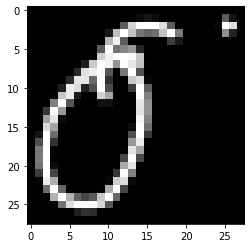

In [9]:
# reformat data and create tokenizations for CLIP
from matplotlib import pyplot as plt

plt.imshow(img_array[0].reshape(28,28), cmap='gray')
plt.show()

CLIP!

In [13]:
# installation dependencies (run this first, then restart kernel)
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

print("Torch version:", torch.__version__)

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Torch version: 1.8.0


In [ ]:
# clone
!git clone https://github.com/openai/CLIP.git

In [1]:
!pip3 install ftfy

In [2]:
from CLIP import clip
from PIL import Image
import numpy as np
import torch
import os

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [39]:
# load model
device = "cuda" if torch.cuda.is_available() else "cpu"
# ViT-B/32 works with 224x224 img 
test_model, transform = clip.load("ViT-B/32", device=device)

In [40]:
# get list of class names
class_names = []
with open(root + 'data/100categories.txt') as f:
    class_names = f.read().splitlines()
target_names = ["a sketch of " + cls for cls in class_names]

In [41]:
# attempt to classify and look @ accuracy
correct = []

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

# define target text classifications
class_text_tokens = clip.tokenize(target_names).to(device)

for cls in class_names:
    class_correct = []
    class_img_array = np.load(root + 'data/' + cls + '.npy')
    for img in class_img_array[:50]:
        pil_img = Image.fromarray(img.reshape((28,28)), 'L')
        image = transform(pil_img).unsqueeze(0)
        with torch.no_grad():
          # encode image and then encode text
            # image_features = test_model.encode_image(image).to(device)
            # text_features = test_model.encode_text(class_text_tokens).to(device)
            # get probs
            logits_per_image, logits_per_text = test_model(image, class_text_tokens)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            # make prediction 
            pred = class_names[argmax(list(probs)[0])]
            if pred == cls:
                correct.append(1)
                class_correct.append(1)
            else:
                correct.append(0)
                class_correct.append(0)
    
    print('accuracy on class ' + cls + ' is: ' + str(sum(class_correct)/len(class_correct)))
print('accuracy on all is: ' + str(sum(correct)/len(correct)))

tensor([[21.8750, 19.4688, 22.4219, 19.0312, 21.5469, 21.8906, 23.7031, 20.6719,
         20.7656, 21.3594, 21.8125, 23.8438, 21.6719, 22.0312, 22.0312, 21.2969,
         22.9375, 19.4688, 22.1250, 22.3125, 21.9844, 21.5000, 20.9219, 20.0000,
         20.0156, 23.0781, 20.8281, 19.3750, 18.1250, 20.4844, 20.7344, 20.9688,
         21.9062, 22.2031, 20.1250, 23.4062, 20.3906, 20.7344, 20.6094, 20.7344,
         24.8125, 19.8281, 19.8594, 22.9375, 20.5938, 21.3125, 20.6562, 20.8438,
         20.0000, 19.8281, 21.6875, 19.4844, 20.4375, 21.2969, 21.7031, 20.1094,
         21.1094, 20.3906, 20.4688, 20.5469, 22.1094, 21.3906, 21.3906, 20.5000,
         21.2500, 22.9375, 24.8594, 20.0938, 21.9219, 21.3125, 20.5469, 22.3594,
         20.3594, 22.2188, 20.9219, 21.5469, 20.2031, 22.9375, 22.5781, 20.0781,
         19.4531, 20.0469, 21.1250, 20.7969, 22.6250, 20.3281, 20.8750, 20.6094,
         20.1250, 20.8438, 20.3750, 20.5938, 21.6719, 20.8125, 18.9375, 20.9375,
         19.1094, 21.7812, 1

KeyboardInterrupt: ignored

In [ ]:
print(class_text_tokens[5])

tensor([49406,   320,  5269,   539, 16637, 49407,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')


Fine-Tuning CLIP

In [42]:
# functions to load in data and construct pytorch dataloader 
def load_dataset(root, mtype):
    num_classes = 100

    if os.path.exists(os.path.join(root, mtype+'.npz')):
        print("*"*50)
        print("Loading "+mtype+" dataset...")
        print("*"*50)
        print("Classes number of "+mtype+" dataset: "+str(num_classes))
        print("*"*50)
        data_cache = np.load(os.path.join(root, mtype+'.npz'))
        return data_cache["data"].astype('float32'), \
            data_cache["target"].astype('int64'), num_classes
    
    else:
        raise FileNotFoundError("%s doesn't exist!" %
                                os.path.join(root, mtype+'.npz'))

class QD_Dataset(torch.utils.data.Dataset):
    def __init__(self, mtype, root):
        """
        args:
        - mytpe: str, specify the type of the dataset, i.e, 'train' or 'test'
        - root: str, specify the root of the dataset directory
        """
        self.data, self.target, self.num_classes = load_dataset(root, mtype)
        print("dataset "+mtype+" loading done.")
        print("*"*50+"\n")

    def __getitem__(self, index):
        curr = self.data[index]
        pil_img = Image.fromarray(curr.reshape((28,28)), 'L')
        pil_img = transform(pil_img)
        caption = "a sketch of " + class_names[self.target[index]]
        return pil_img, caption

    def __len__(self):
        return len(self.data)

    def get_number_classes(self):
        return self.num_classes

In [43]:
train_dataset = QD_Dataset(mtype = "train", root=root+"data/datasets")

**************************************************
Loading train dataset...
**************************************************
Classes number of train dataset: 100
**************************************************
dataset train loading done.
**************************************************



In [44]:
# 400,000 images (400 per class in training) (the other 100 in test!)
# class_names array maps from index to class name
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [45]:
test_model, transform = clip.load("ViT-B/32", device='cuda', jit=False)

In [51]:
# freeze first n layers
def freeze(model, num_layers_to_freeze):
  ct = 0
  for child in model.children():
    ct += 1
    if ct < num_layers_to_freeze:
        for param in child.parameters():
            param.requires_grad = False

# train function
def finetune_CLIP(model, train_loader, num_epochs):
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params from paper
  loss_img = torch.nn.CrossEntropyLoss()
  loss_txt = torch.nn.CrossEntropyLoss()
  loss_epoch = 0
  for e in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      # get img and text features
      images = torch.stack([img for img in inputs], dim=0).to(device)
      text_features = clip.tokenize(labels).to(device)
      # get logit outputs
      logits_per_image, logits_per_text = model(images, text_features)
      # get ground truth
      ground_truth = torch.arange(inputs.size(0)).long().to(device)
      # compute loss
      total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text,ground_truth))/2
      loss_epoch += total_loss.item()
      total_loss.backward()
      optimizer.step()
      if ((i+1) % 100) == 0:
        print(total_loss.item())
    print("Epoch %d, Loss: %f" % (e+1, loss_epoch/len(trainloader)))
    # reset loss every epoch
    loss_epoch = 0
  print("Finished training!")

In [ ]:
# freeze language transformer?
for k in test_model.transformer.parameters():  
  k.requires_grad=False

In [48]:
def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

In [52]:
finetune_CLIP(test_model, train_loader, 5)

4.16015625
4.16015625
4.16015625
4.17578125
4.15625
4.15625
4.16015625
4.16015625
4.15625


RuntimeError: ignored